# Import

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import warnings; warnings.simplefilter('ignore')

# Read csv

In [2]:
weather_data = pd.read_csv('./data/weatherstats_edmonton_hourly.csv')
mos_data = pd.read_csv('./data/Mosquito_Trap_Data.csv')

In [3]:
weather_data.head()

,date_time_local,unixtime,pressure_station,pressure_sea,wind_dir,wind_dir_10s,wind_speed,wind_gust,relative_humidity,dew_point,temperature,windchill,humidex,visibility,health_index,cloud_cover_4,cloud_cover_8,cloud_cover_10,solar_radiation
0,2018-12-18 16:00:00 MST,1545174000,91.73,99.7,SW,23.0,5.0,NaN,64.0,-7.3,-1.3,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-12-18 15:00:00 MST,1545170400,91.67,99.7,S,18.0,5.0,NaN,65.0,-6.3,-0.5,-2.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN
2,2018-12-18 14:00:00 MST,1545166800,91.67,99.6,S,17.0,5.0,NaN,51.0,-6.5,2.7,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
3,2018-12-18 13:00:00 MST,1545163200,91.66,99.6,SE,13.0,2.0,NaN,50.0,-6.4,2.9,NaN,NaN,NaN,3.9,NaN,NaN,NaN,NaN
4,2018-12-18 12:00:00 MST,1545159600,91.75,99.7,NaN,NaN,0.0,NaN,59.0,-6.6,0.5,NaN,NaN,NaN,4.1,NaN,NaN,NaN,NaN


In [4]:
mos_data.head()

,Trap Date,Genus,Specific Epithet,Gender,IDd,Count,Trap Region,Include,Comparison Group,Latitude,Longitude,Location
0,09/15/2015 12:00:00 AM,Aedes,vexans,Female,NaN,3,Rural-West,NaN,Outer,53.562973,-113.787353,POINT (-113.787353 53.5629733)
1,05/12/1998 12:00:00 AM,Male,UnID,Male,UnID,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
2,08/28/2001 12:00:00 AM,Culex,tarsalis,Female,NaN,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
3,08/17/2004 12:00:00 AM,Culex,territans,Female,NaN,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
4,05/15/2018 12:00:00 AM,Culiseta,impatiens,Female,NaN,2,Rural-West,NaN,Outer,53.559020,-114.001190,POINT (-114.00119 53.559020000000004)


# Date

In [5]:
t_list = []
for i in mos_data['Trap Date']:
    i = str(i)
    t1 = time.strptime(i,"%m/%d/%Y %H:%M:%S AM")
    t2 = time.strftime("%Y-%m-%d", t1)
    t_list.append(t2)

mos_data['Trap Date'] = t_list
mos_data['Trap Date'] = pd.to_datetime(mos_data['Trap Date'])

############data select#############
start_remove = min(weather_data['date_time_local'])
end_remove = max(weather_data['date_time_local'])
mos_data_1 = mos_data.loc[(mos_data["Trap Date"] > start_remove) & (mos_data["Trap Date"] < end_remove) ]
mos_date_start = str(mos_data_1['Trap Date'].dt.date.min())
mos_date_end = str(mos_data_1['Trap Date'].dt.date.max())
mos_date_range = mos_date_start +' to ' + mos_date_end
print("Range of dates in mosquito dataset is {}".format(mos_date_range))

mos_data['Trap Date'] = pd.to_datetime(mos_data['Trap Date'])
mos_range = (mos_data['Trap Date'] > mos_date_start) & (mos_data['Trap Date'] < mos_date_end)
mos_data = mos_data.loc[mos_range]
mos_data = mos_data.sort_values(by='Trap Date')

Range of dates in mosquito dataset is 2017-05-09 to 2018-09-25


In [6]:
mos_data.head()

,Trap Date,Genus,Specific Epithet,Gender,IDd,Count,Trap Region,Include,Comparison Group,Latitude,Longitude,Location
19195,2017-05-16,Ochlerotatus,Black legs,Female,UnID,13,Residential GC-South,NaN,Core,53.482057,-113.418346,POINT (-113.4183455 53.4820573)
6338,2017-05-16,Ochlerotatus,Black legs,Female,UnID,1,Outer Community-South1,NaN,Outer,53.333327,-113.531374,POINT (-113.5313737 53.3333269)
888,2017-05-16,Culiseta,alaskaensis,Female,NaN,1,Residential GC-South,NaN,Core,53.482057,-113.418346,POINT (-113.4183455 53.4820573)
26275,2017-05-16,Male,UnID,Male,UnID,1,River Valley-East-P1,NaN,Core,53.581417,-113.374561,POINT (-113.3745611 53.58141700000001)
18595,2017-05-16,Culiseta,inornata,Female,NaN,1,Rural-North West,NaN,Peripheral,53.619232,-113.712798,POINT (-113.7127984 53.6192317)


# Weather date

In [7]:
start_date1 = '2017-05-10'
end_date1 = '2017-09-26'
start_date2 = '2018-05-09'
end_date2 = '2018-09-18'

##############Drop###################
weather_data.drop(columns=["visibility", "cloud_cover_4", "cloud_cover_8", "cloud_cover_10", "solar_radiation", "wind_gust", "windchill", "humidex"], inplace=True)
weather_data = weather_data.loc[weather_data['date_time_local'].str.contains('MDT')]


t_list = []
for i in weather_data['date_time_local']:
    i = str(i)
    t1 = time.strptime(i,"%Y-%m-%d %H:%M:%S MDT")
    t2 = time.strftime("%Y-%m-%d", t1)
    t_list.append(t2)

weather_data['date_time_local'] = t_list

weather_data['date_time_local'] = pd.to_datetime(weather_data['date_time_local'])
weather_range1 = (weather_data['date_time_local'] >= start_date1) & (weather_data['date_time_local'] <= end_date1)
weather_data1 = weather_data.loc[weather_range1]
weather_data1 = weather_data1.sort_values(by='date_time_local')

weather_range2 = (weather_data['date_time_local'] >= start_date2) & (weather_data['date_time_local'] <= end_date2)
weather_data2 = weather_data.loc[weather_range2]
weather_data2 = weather_data2.sort_values(by='date_time_local')
weather_data = weather_data1.append(weather_data2)

# Calculate count of male and female

In [8]:
mos_data_male = mos_data.loc[mos_data['Gender'].str.contains('Male')]
mos_data_female = mos_data.loc[mos_data['Gender'].str.contains('Female')]

mos_count_male = mos_data_male.groupby(["Trap Date"]).agg({
    "Count":"sum",
})
mos_count_male[mos_count_male['Count'] == mos_count_male['Count'].max()]

,Count
Trap Date,
2018-06-12,6637


In [9]:
mos_count_male.head()

,Count
Trap Date,
2017-05-16,6
2017-05-23,325
2017-05-30,213
2017-06-06,1130
2017-06-13,1708


In [10]:
mos_count_female = mos_data_female.groupby(["Trap Date"]).agg({
    "Count":"sum",
})
mos_count_female[mos_count_female['Count'] == mos_count_female['Count'].max()]

,Count
Trap Date,
2018-07-10,4490


In [11]:
mos_count_female.head()

,Count
Trap Date,
2017-05-16,23
2017-05-23,198
2017-05-30,150
2017-06-06,526
2017-06-13,1261


# Classify

In [12]:
mos_count_male["Count_female"] = mos_count_female["Count"]
mos_count_male['Gender'] = np.where(mos_count_male["Count"] > mos_count_male["Count_female"], 'Male', 'Female')
gender = np.array(mos_count_male['Gender'])

In [13]:
gender

array(['Female', 'Male', 'Male', 'Male', 'Male', 'Male', 'Male', 'Female',
       'Female', 'Female', 'Female', 'Female', 'Female', 'Female',
       'Female', 'Female', 'Female', 'Male', 'Female', 'Female', 'Male',
       'Male', 'Male', 'Male', 'Male', 'Male', 'Female', 'Female',
       'Female', 'Female', 'Female', 'Female', 'Male', 'Male', 'Male',
       'Male', 'Male', 'Male', 'Male'], dtype=object)

# Weather features

In [14]:
loc = weather_data.columns.get_loc("temperature")
temp = np.ones(int(len(weather_data)/(24*7)))
af = []
for i in range(int(len(weather_data)/(24*7))):
    af = weather_data.iloc[0:((i+1)*24*7), loc]#temp
    temp[i] = af.mean()


loc = weather_data.columns.get_loc("relative_humidity")
hum = np.ones(int(len(weather_data)/(24*7)))
af = []
for i in range(int(len(weather_data)/(24*7))):
    af = weather_data.iloc[0:((i+1)*24*7), loc]
    hum[i] = af.mean()


loc = weather_data.columns.get_loc("wind_speed")
wind = np.ones(int(len(weather_data)/(24*7)))
af = []
for i in range(int(len(weather_data)/(24*7))):
    af = weather_data.iloc[0:((i+1)*24*7), loc]
    wind[i] = af.mean()


loc = weather_data.columns.get_loc("dew_point")
dew = np.ones(int(len(weather_data)/(24*7)))
af = []
for i in range(int(len(weather_data)/(24*7))):
    af = weather_data.iloc[0:((i+1)*24*7), loc]
    dew[i] = af.mean()


loc = weather_data.columns.get_loc("health_index")
health = np.ones(int(len(weather_data)/(24*7)))
af = []
for i in range(int(len(weather_data)/(24*7))):
    af = weather_data.iloc[0:((i+1)*24*7), loc]
    health[i] = af.mean()
    
len(temp)

39

In [16]:
c = (temp,hum,wind,dew,health,gender)
c = np.array(c)
c = np.vstack(c)

In [18]:
a = pd.DataFrame({'temp':temp,'humidity':hum,'wind':wind,'dew':dew,'health':health,'gender':gender})
cat = a['gender'].values
x1 = a['humidity'].values
x2 = a['wind'].values

In [19]:
cat1 = np.ones(len(cat))  #for poly
for j in range(len(cat)):
    if cat[j]=='Male':
        cat1[j] = 0
    else:
        cat1[j] = 1

Labels = cat1.reshape(len(cat1),1)

# Logistic regression 

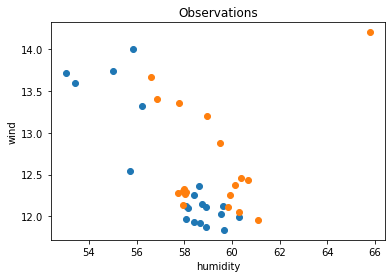

In [20]:
logreg = linear_model.LogisticRegression(solver='lbfgs')
Features = np.array([x1, x2]).T
logreg.fit(Features,cat)
Ypre = logreg.predict(Features)
plt.scatter(x1[cat=='Male'],x2[cat=='Male'], label='Male')
plt.scatter(x1[cat=='Female'],x2[cat=='Female'], label='Female')
plt.title('Observations')
plt.xlabel('humidity')
plt.ylabel('wind')
plt.show()

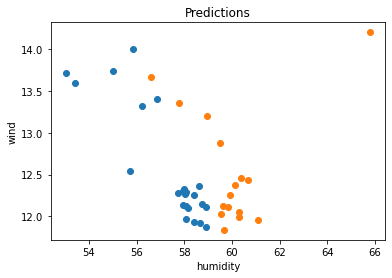

In [21]:
plt.scatter(x1[Ypre=='Male'],x2[Ypre=='Male'])
plt.scatter(x1[Ypre=='Female'],x2[Ypre=='Female'])
plt.title('Predictions')
plt.xlabel('humidity')
plt.ylabel('wind')
plt.show()

In [22]:
cm = confusion_matrix(cat, Ypre)
print(pd.DataFrame(cm))
tn, fp, fn, tp = cm.flatten()
tot = np.sum(cm)
print("Model accuracy:",(tn+tp)/tot)
print("Misclassified:",(fn+fp)/tot)
print("% of error of true No:",fn/(fn+tn)*100)
print("% of error of true Yes:",fp/(fp+tp)*100)

    0   1
0  12   7
1   4  16
Model accuracy: 0.717948717948718
Misclassified: 0.28205128205128205
% of error of true No: 25.0
% of error of true Yes: 30.434782608695656


# Polynomial

In [23]:
x3 = (x1,x2)
x3 = np.array(x3)
x3 = x3.T

In [24]:
poly_features = PolynomialFeatures(degree = 2)
logreg = linear_model.LogisticRegression(solver='lbfgs',multi_class='auto')
X_poly = poly_features.fit_transform(x3)
logreg.fit(X_poly,cat1)
Yp = logreg.predict(X_poly)
cm = confusion_matrix(cat1, Yp)
print(pd.DataFrame(cm))
tn, fp, fn, tp = cm.flatten()
tot = np.sum(cm)
print("Model accuracy:",(tn+tp)/tot)
print("Misclassified:",(fn+fp)/tot)
print("% of error of true No:",fn/(fn+tn)*100)
print("% of error of true Yes:",fp/(fp+tp)*100)

    0   1
0  16   4
1   6  13
Model accuracy: 0.7435897435897436
Misclassified: 0.2564102564102564
% of error of true No: 27.27272727272727
% of error of true Yes: 23.52941176470588


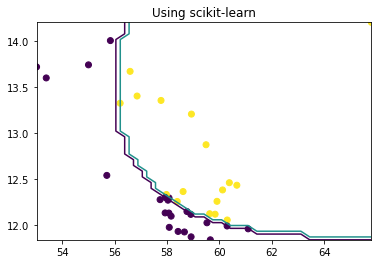

In [25]:
xg = np.linspace(x1.min(), x1.max(), len(x1))
yg = np.linspace(x2.min(), x2.max(), len(x2))
xx, yy = np.meshgrid(xg,yg)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
Xcont = poly_features.fit_transform(np.vstack((xx.ravel(),yy.ravel())).T)
Z = logreg.predict(Xcont).reshape(xx.shape)
plt.contour(xx,yy,Z,levels=1)
plt.scatter(x1,x2,c=Yp)
plt.title("Using scikit-learn")
plt.show()

In [26]:
print("Model accuracity:",accuracy_score(cat1,Yp))

Model accuracity: 0.7435897435897436


# SVM

In [27]:
def plot_svm_decision_margin(model, plot_support=True):
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                   s=200, linewidth=1, edgecolors='black', facecolors='none');
    plt.show()

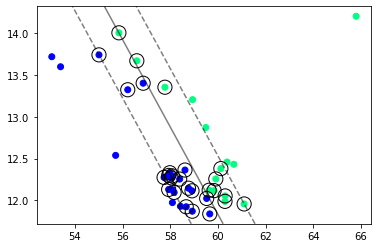

In [28]:
model_soft = SVC(kernel='linear')
model_soft.fit(x3, cat1)
Yp_soft = model_soft.predict(x3)
plt.scatter(x1, x2, c=Yp_soft, cmap='winter')
plot_svm_decision_margin(model_soft)

In [29]:
print("Soft Margin Model accuracity:",accuracy_score(cat1,Yp_soft))

Soft Margin Model accuracity: 0.7435897435897436
